# Data setup

In [294]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
import torch
import os
import math
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline


In [295]:
def sigma_fn(c, w_0=0.5, w_1=7):
    return w_0 ** 2 + (w_1 ** 2) * c

def sigma_dw_0(c, w_0, w_1):
    return 2 * w_0

def sigma_dw_1(c, w_0, w_1):
    return 2 * w_1 * c

num_samples = 10000
x = np.array([3])

c = np.random.rand(num_samples)
sigma_2 = sigma_fn(c)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
y = x + eps

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


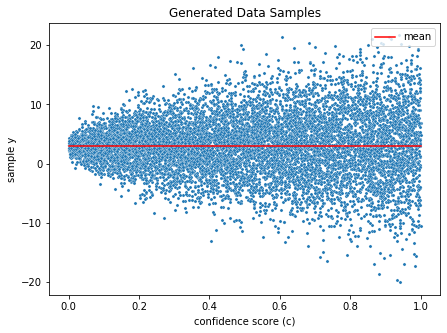

In [296]:
plt.figure(figsize=(7, 5))
sns.scatterplot(c, y, s=10)

# Bigger c value = more variance/uncertainty
plt.xlabel('confidence score (c)')
plt.ylabel('sample y')
plt.title("Generated Data Samples")
plt.plot([0, 1], [y.mean(), y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

In [297]:
y[c < 0.1].std(), y[c > 0.9].std()

(1.7038460082033182, 6.832725598241097)

# 1.1: Frequentist approach

In [301]:
def l_dmu(mu, w_0, w_1):
    return ((y - mu) / sigma_fn(c, w_0, w_1)).sum()

def l_dw0(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_0(c, w_0, w_1)
            - (sigma_dw_0(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

def l_dw1(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_1(c, w_0, w_1)
            - (sigma_dw_1(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()
def l_jac(params):
    mu, w_0, w_1 = params
    return - np.array([l_dmu(mu, w_0, w_1),
                     l_dw0(mu, w_0, w_1),
                     l_dw1(mu, w_0, w_1),
                    ])
def log_fn(params):
    mu = params[0]
    w_0 = params[1]
    w_1 = params[2]
    
    first = (y - mu) ** 2 / sigma_fn(c, w_0=w_0, w_1=w_1)
    second = np.log(sigma_fn(c, w_0=w_0, w_1=w_1))
    return first.sum() + second.sum()

In [306]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, [14, 15, 12], jac=l_jac, method='Newton-CG').x
mu_mle, w0_mle, w1_mle

(3.0063876289790135, -0.5678766525710585, 7.0182059486633905)

# 1.2 Frequentist Regression

In [232]:
def sigma_fn_2(c, v_0=0.5, v_1=7):
    return v_0 ** 2 + (v_1 ** 2) * c

def sigma_2_dv_0(c, v_0, v_1):
    return 2 * v_0

def sigma_2_dv_1(c, v_0, v_1):
    return 2 * v_1 * c

def phi(x):
    return np.array([x ** 0, x, x ** 2]).squeeze()

num_samples = 1000

# x = np.random.randint(0, 101, size=num_samples)
# x = np.random.rand(num_samples)
x = np.linspace(-11,10, num_samples)

# c = np.zeros(num_samples)
c = np.random.rand(num_samples) + 10

# w_0 = 13
# w_1 = 0.9
# w_2 = 0.02
# v_0 = 0.01
# v_1 = 0

w_0 = 1.3
w_1 = 12
w_2 = 21
v_0 = 10
v_1 = 33


w = np.array([w_0, w_1, w_2]).squeeze()
v = np.array([v_0, v_1]).squeeze()
sigma_2 = sigma_fn_2(c, v_0=v_0, v_1=v_1)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
# assert x.shape == (num_samples,)
y = w.T @ phi(x) + eps
y_true = w.T @ phi(x)
assert y.shape == (num_samples,)
assert y_true.shape == (num_samples,)

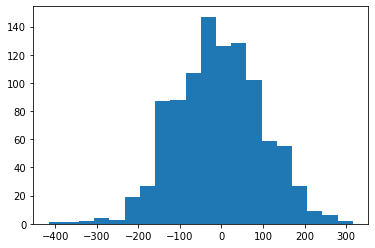

In [233]:
plt.hist(eps, bins=20);

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


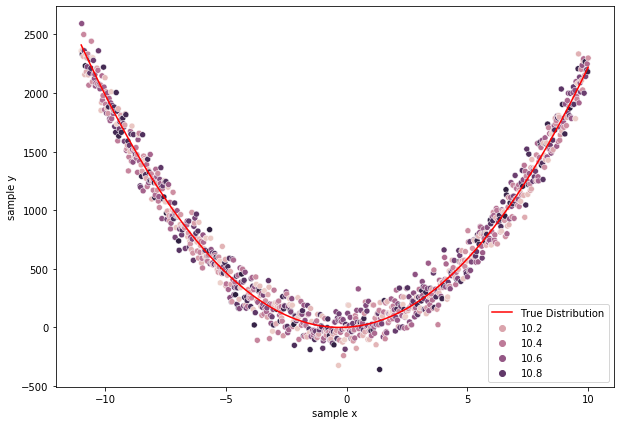

In [234]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x,
                y,
                hue=c,
                )
plt.plot(x, y_true, 'r', label="True Distribution")
plt.xlabel('sample x')
plt.ylabel('sample y')
plt.legend(loc='lower right');

In [235]:
Phi = phi(x)
F = sigma_2 * np.eye(len(sigma_2))
F_inv = np.linalg.inv(F)

def log_fn(params):
    w = params[0: 3]
    v = params[3: ]

    first = (w.T @ phi(x) - y) ** 2 / sigma_fn_2(c, *v)
    second = np.log(sigma_fn_2(c, *v))
    return - 0.5 * (first.sum() + second.sum())


def l_deriv_w(w, v):
    # F_minus1 = np.linalg.inv(F(v))
    # result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
    # result = Phi.T @ ((w.T @ Phi - y) / sigma_fn_2(c, *v))
    result = Phi @ F_inv @ Phi.T @ w - Phi @ F_inv @ y
    return - result

def l_deriv_v0(w, v):
    first = (w @ Phi - y) * sigma_2_dv_0(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_0(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_deriv_v1(w, v):
    first = (w @ Phi - y) * sigma_2_dv_1(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_1(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_jac(params):
    w = params[0: 3]
    v = params[3: ]
    return - np.array([*l_deriv_w(w, v),
                       l_deriv_v0(w, v),
                       l_deriv_v1(w, v),
                       ])

In [236]:
minimize(log_fn, np.append(w,v), jac=l_jac, method='Newton-CG')

     fun: -5198.408747814966
     jac: array([  -1.89046678,    2.53431194, -144.91230604,    1.93493118,
         63.62706553])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 23
    nhev: 0
     nit: 1
    njev: 15
  status: 2
 success: False
       x: array([ 1.28044789, 12.04253515, 20.21129344,  9.94789604, 31.19707227])

In [237]:
w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle = minimize(log_fn, np.append(w,v), jac=l_jac, method='Newton-CG').x
w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle

(1.2804478933105128,
 12.042535145682542,
 20.211293442483488,
 9.94789603581361,
 31.197072273235687)

# 1.3 Bayesian approach

## Generate Sample Data
Data generated according to:
$$y = f(x) + \epsilon(c) \hspace{.3cm} f \sim GP(0,k)$$

For this example we will choose an RBF kernel

In [341]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

n_samples = 100

train_x = torch.linspace(1, 100, n_samples)
test_x = torch.linspace(1, 100, n_samples)
### Make GP

likelihood = gpytorch.likelihoods.GaussianLikelihood()

RBF_kernel = gpytorch.kernels.RBFKernel()
RBF_kernel.has_lengthscale = True
RBF_kernel.lengthscale = 7.3
RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
RBF_model.covar_module.outputscale = 12.4
RBF_model.eval()


RBF_pred = RBF_model(train_x)
RBF_samples = RBF_pred.rsample(sample_shape=torch.Size([1]))



v_0 = 0.521
v_1 = 1.783
v = np.array([v_0, v_1]).squeeze()

### Make Sigma Values
#c = np.random.normal(size=n_samples)
c = np.random.rand(n_samples) - .5

print(np.min(c))
print(np.max(c))

def sigma_fn_3(c, v_0=v_0, v_1=v_1):
    return v_0**2 + (v_1)**2 * c

def gamma_fn_3(c, v_0=v_0, v_1=v_1):
    return v_0**2 + (v_1**2) * c

sigma2 = sigma_fn_3(c, v_0, v_1) #1/gamma_fn_3(c, v_0, v_1)

### Make Sample Data
y = (RBF_samples.detach().numpy() + sigma2)[0]

-0.49615760830174527
0.4947628767375222


(array([10.,  9.,  9., 15., 13.,  7.,  9., 13.,  6.,  9.]),
 array([-1.30588819, -0.99086575, -0.67584331, -0.36082087, -0.04579843,
         0.26922401,  0.58424645,  0.89926889,  1.21429134,  1.52931378,
         1.84433622]),
 <a list of 10 Patch objects>)

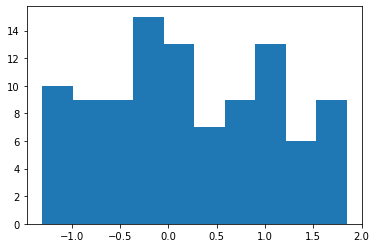

In [342]:
### Checking for Gaussian Noise
plt.hist(sigma2)

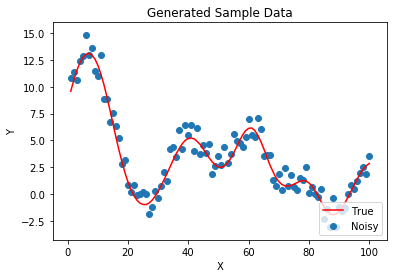

In [343]:
### Plotting Noisy Data vs. True Function
plt.plot(train_x, RBF_samples.detach().numpy()[0], 'r-', label="True")
plt.scatter(train_x, y, label="Noisy")
plt.title("Generated Sample Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="lower right")

## Derivative Equations

Marginal Likelihood: 
$$ \ell(\theta, v)  = \log p(y| \theta, v) = -\frac{1}{2} y^T(K_\theta + F)^{-1} y - \frac{1}{2} \log|K_\theta + F| - \frac{N}{2} \log(2 \pi) $$

$$\alpha =(K_\theta + F)^{-1}y $$


Derivative Equations: 
$$
\begin{align}
    \frac{\partial \ell}{\partial v_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial F}{\partial v_j}  ) \\
    \frac{\partial \ell}{\partial \theta_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial K_{\theta}}{\partial \theta_j}  )
\end{align}
$$

$$ \theta_1 = \text{Lengthscale}, \theta_2 = \text{Output Scale} $$


For an RBF Kernel, K is:

$$
\begin{align}
    K_{\theta} = a^2 exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{a}} = 2a \cdot exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{L}} = \Big(K_{\theta} \Big) \Big(\frac{||x-x'||^2}{L^3} \Big)
\end{align}
$$


In [336]:
K_theta = RBF_kernel(train_x).evaluate() + torch.eye(RBF_kernel(train_x).evaluate().shape[0]) * sigma2
lengthscale = RBF_model.covar_module.base_kernel.lengthscale.item()
outputscale = RBF_model.covar_module.outputscale.item()


def dL_lengthscale(v, lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    alpha = KF_inv @ y
    dK_lengthscale = KF_inv @ ((np.log(K_theta.detach().numpy() / outputscale) * -2) / np.sqrt(lengthscale))
    
    return .5 * np.trace(alpha @ alpha.T - dK_lengthscale)


def dL_outputscale(v, lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    alpha = KF_inv @ y
    dK_outputscale = 2 * (K_theta / outputscale) * np.sqrt(outputscale)
    dK_outputscale = dK_outputscale.detach().numpy()
    
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dK_outputscale)
    
    
def dL_dv0(v,lengthscale, outputscale):
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    dF_dv0 = np.eye(len(sigma2)) * 2* v[0]
    alpha = KF_inv @ y
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv0)


def dL_dv1(v,lengthscale, outputscale): 
    sigma2 = sigma_fn_3(c, *v)
    F = sigma2 * np.eye(len(sigma2))
    KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
    dF_dv1 = np.eye(len(sigma2)) * 2 * c * v[1]
    alpha = KF_inv @ y
    return .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv1)




print("Derivative wrt Lengthscale: ", dL_lengthscale(v,lengthscale, outputscale))
print("Derivative wrt Output Scale: ", dL_outputscale(v,lengthscale, outputscale))
print("Derivative wrt v_0: ", dL_dv0(v,lengthscale, outputscale))
print("Derivative wrt v_1: ", dL_dv1(v,lengthscale, outputscale))


Derivative wrt Lengthscale:  8205.809904104457
Derivative wrt Output Scale:  8188.256522892416
Derivative wrt v_0:  8204.428686904419
Derivative wrt v_1:  8161.376752031673


## Optimization Step

In [337]:
class noisyRBF_Kernel(gpytorch.kernels.RBFKernel):
    def __init__(self, sigma_param, *args, **kwargs):
        super(gpytorch.kernels.RBFKernel, self).__init__()
        self.v_0 = torch.tensor(sigma_param[0], requires_grad = True)
        self.v_1 = torch.tensor(sigma_param[1], requires_grad = True)
        self.sigma_output = sigma_fn_3(c, self.v_0.detach().numpy(), self.v_1.detach().numpy())



test = noisyRBF_Kernel([0.521,1.783])
test.has_lengthscale = True
test.lengthscale = lengthscale
test = gpytorch.kernels.ScaleKernel(test)
RBF_model = ExactGPModel(None, None, likelihood, test)
RBF_model.covar_module.outputscale = outputscale
RBF_model.covar_module.base_kernel.v_0


tensor(0.5210, requires_grad=True)

In [338]:
RBF_model.covar_module.outputscale

tensor(12.4000, grad_fn=<SoftplusBackward>)

In [339]:
# F = sigma2 * np.eye(len(sigma2))
# KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
# likelihood = np.exp(-.5 * y.T @ KF_inv @ y ) / ( (2 * np.pi)**(len(y)/2) * np.linalg.det(K_theta.detach().numpy() + F))

# RBF_kernel = gpytorch.kernels.RBFKernel()
# RBF_kernel.has_lengthscale = True
# RBF_kernel.lengthscale = lengthscale
# RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
# RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
# RBF_model.covar_module.outputscale = outputscale
# K_theta = RBF_kernel(train_x).evaluate() + torch.eye(RBF_kernel(train_x).evaluate().shape[0]) * sigma2




### function to calculate log likelihood


# def log_fn(params):
#     v = params[:2]
#     lengthscale = params[2]
#     outputscale = params[3]
    
#     sigma2 = sigma_fn_3(c, *v)
    
    
#     RBF_kernel = gpytorch.kernels.RBFKernel()
#     RBF_kernel.has_lengthscale = True
#     RBF_kernel.lengthscale = lengthscale
#     RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
#     RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
#     RBF_model.covar_module.outputscale = outputscale
#     K_theta = RBF_kernel(train_x).evaluate() + torch.eye(RBF_kernel(train_x).evaluate().shape[0]) * sigma2
    
    
    
#     F = sigma2 * np.eye(len(sigma2))
#     KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
#     alpha = KF_inv @ y
# #     dK_lengthscale = KF_inv @ ((np.log(K_theta.detach().numpy() / outputscale) * -2) / np.sqrt(lengthscale))
# #     dK_outputscale = 2 * (K_theta / outputscale) * np.sqrt(outputscale)
# #     dK_outputscale = dK_outputscale.detach().numpy()
    
#     first = 0.5 * y.T @ alpha
#     interior = np.linalg.det(K_theta.detach().numpy() + F)
#     if interior <=0:
#         print(v)
#     second = 0.5 * np.log(np.linalg.det(K_theta.detach().numpy() + F))
# #     third = - (len(y) / 2) * np.log(2 * np.pi)

#     return (first + second) 

# def l_jac(params):
#     v = params[:2]
#     lengthscale = params[2]
#     outputscale = params[3]
    
    
#     sigma2 = sigma_fn_3(c, *v)
    
#     RBF_kernel = gpytorch.kernels.RBFKernel()
#     RBF_kernel.has_lengthscale = True
#     RBF_kernel.lengthscale = lengthscale
#     RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
#     RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
#     RBF_model.covar_module.outputscale = outputscale
#     K_theta = RBF_kernel(train_x).evaluate() + torch.eye(RBF_kernel(train_x).evaluate().shape[0]) * sigma2
    
#     return - np.array([dL_lengthscale(v,lengthscale, outputscale), 
#                        dL_outputscale(v,lengthscale, outputscale), 
#                        dL_dv0(v,lengthscale, outputscale), 
#                        dL_dv1(v,lengthscale, outputscale),
#                        ])

# new = np.append(v + 4, outputscale)
# new = np.append(new,lengthscale)
# print(new)




likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.tensor(sigma2))
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

# RBF_kernel = gpytorch.kernels.RBFKernel()
# RBF_kernel.has_lengthscale = True
# RBF_kernel.lengthscale = lengthscale
# RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
# RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
# RBF_model.covar_module.outputscale = outputscale
# K_theta = RBF_kernel(train_x).evaluate() + torch.eye(RBF_kernel(train_x).evaluate().shape[0]) * sigma2



noisyRBF = noisyRBF_Kernel([0.521,1.783])
noisyRBF.has_lengthscale = True
noisyRBF.lengthscale = lengthscale
noisyRBF = gpytorch.kernels.ScaleKernel(noisyRBF)
RBF_model = ExactGPModel(None, None, likelihood, noisyRBF)
RBF_model.covar_module.outputscale = outputscale


smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


RBF_model.train()
likelihood.train()

parameters = list(RBF_model.parameters())
v_0 = torch.tensor(v_0, requires_grad = True)
v_1 = torch.tensor(v_1, requires_grad = True)
parameters.append(v_0)
parameters.append(v_1)
parameters.append(likelihood.noise)


optimizer = torch.optim.Adam(parameters, lr=.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, RBF_model)


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    RBF_model.set_train_data(train_x, strict=False)
    output = RBF_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, torch.DoubleTensor(y))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   outputscale: %.3f   v_0: %.3f   v_1: %.3f' % (
        i + 1, training_iter, loss.item(),
        RBF_model.covar_module.base_kernel.lengthscale.item(),
        RBF_model.covar_module.outputscale.item(),
        v_0.item(), v_1.item()
#         RBF_model.likelihood.noise.item()
    ))
#     print(likelihood.noise, "\n\n")
    optimizer.step()



RBF_model.likelihood.noise

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [146]:
# minimize(log_fn, new+4, jac=l_jac, method='Newton-CG')
minimize(log_fn, new + 4, method='Nelder-Mead')
# minimize(log_fn, new+4, jac=l_jac, method='Powell')
# minimize(log_fn, new+4, jac=l_jac, method='SLSQP')


 final_simplex: (array([[ 6.47827190e-01, -7.03063965e-03,  7.60368471e+00,
         3.24703875e+01],
       [ 6.47827181e-01, -7.03051103e-03,  7.60368510e+00,
         3.24703872e+01],
       [ 6.47827181e-01, -7.03051013e-03,  7.60368507e+00,
         3.24703872e+01],
       [ 6.47827172e-01, -7.03061069e-03,  7.60368485e+00,
         3.24703875e+01],
       [ 6.47827172e-01, -7.03056313e-03,  7.60368504e+00,
         3.24703873e+01]]), array([76.31118255, 76.31118255, 76.31118255, 76.31118255, 76.31118255]))
           fun: 76.31118255022274
       message: 'Optimization terminated successfully.'
          nfev: 345
           nit: 168
        status: 0
       success: True
             x: array([ 6.47827190e-01, -7.03063965e-03,  7.60368471e+00,  3.24703875e+01])

## Prediction